### L.A. County places timeseries

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date
from slugify import slugify

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

In [6]:
cases = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/places/timeseries.csv",
    low_memory=False,
)

### Get places in Los Angeles County

In [7]:
places = cases[(cases["zcta_id"].isna()) & (cases["county"] == "Los Angeles")]

In [8]:
places_latest = places[places["date"] == places["date"].max()]

In [9]:
places_latest.head()

,name,date,county,fips,slug,confirmed_cases_note,confirmed_cases,lat,lon,population,zcta_id,id,new_confirmed_cases,new_confirmed_cases_seven_day_total,new_confirmed_cases_seven_day_average,new_confirmed_cases_fourteen_day_total,new_confirmed_cases_fourteen_day_average,confirmed_cases_per_100k,new_confirmed_cases_per_100k,new_confirmed_cases_seven_day_per_100k,new_confirmed_cases_fourteen_day_per_100k
66956,Acton,2021-02-10,Los Angeles,37,unincorporated-acton,NaN,409,34.481366,-118.216138,7971.0,NaN,Unincorporated - Acton,0.0,9.0,1.285714,21.0,1.500000,5131.100238,0.0,112.909296,263.455024
67288,Adams-Normandie,2021-02-10,Los Angeles,37,los-angeles-adams-normandie,NaN,1118,34.029122,-118.302396,8202.0,NaN,Los Angeles - Adams-Normandie,0.0,27.0,3.857143,73.0,5.214286,13630.821751,0.0,329.188003,890.026823
67620,Agoura Hills,2021-02-10,Los Angeles,37,city-of-agoura-hills,NaN,907,34.151007,-118.760876,20883.0,NaN,City of Agoura Hills,0.0,24.0,3.428571,59.0,4.214286,4343.245702,0.0,114.926016,282.526457
67952,Agua Dulce,2021-02-10,Los Angeles,37,unincorporated-agua-dulce,NaN,242,34.497963,-118.323810,4158.0,NaN,Unincorporated - Agua Dulce,0.0,11.0,1.571429,37.0,2.642857,5820.105820,0.0,264.550265,889.850890
68284,Alhambra,2021-02-10,Los Angeles,37,city-of-alhambra,NaN,6430,34.083961,-118.135504,86724.0,NaN,City of Alhambra,0.0,145.0,20.714286,380.0,27.142857,7414.325907,0.0,167.197085,438.171671


In [10]:
len(places_latest)

334

---

### Cases during the surge? 

In [11]:
surge_places = places[
    (places["date"] > "2020-11-01") & (places["date"] < "2020-12-15")
][["name", "date", "new_confirmed_cases_seven_day_average"]]

In [12]:
losangeles = surge_places[
    (surge_places["name"].str.contains("Leimert Park"))
    | surge_places["name"].str.contains("Playa Del Rey")
]

In [13]:
alt.Chart(losangeles).mark_line().encode(
    x=alt.X("date:T"),
    y="new_confirmed_cases_seven_day_average",
    facet=alt.Facet("name:N", columns=2),
)

alt.Chart(...)

### Change from Nov. 15 to Dec. 15?

In [14]:
surge_change = places[
    (places["date"] == "2020-11-15") | (places["date"] == "2020-12-15")
][["name", "date", "new_confirmed_cases_seven_day_per_100k"]]

In [15]:
surge_change.head()

,name,date,new_confirmed_cases_seven_day_per_100k
66869,Acton,2020-11-15,75.272864
66899,Acton,2020-12-15,414.000753
67201,Adams-Normandie,2020-11-15,207.266520
67231,Adams-Normandie,2020-12-15,816.873933
67533,Agoura Hills,2020-11-15,71.828760


In [16]:
surge_change_pivot = (
    pd.pivot_table(
        surge_change[surge_change["new_confirmed_cases_seven_day_per_100k"] > 0],
        values="new_confirmed_cases_seven_day_per_100k",
        index=["name"],
        columns=["date"],
        fill_value=0,
    )
    .dropna()
    .reset_index()
)

In [17]:
surge_change_pivot.rename(
    columns={"2020-11-15": "mid_november", "2020-12-15": "mid_december"}, inplace=True
)

In [18]:
surge_change_pivot.head()

date,name,mid_november,mid_december
0,Acton,75.272864,414.000753
1,Adams-Normandie,207.266520,816.873933
2,Agoura Hills,71.828760,330.412297
3,Agua Dulce,240.500241,408.850409
4,Alhambra,96.859001,522.346755


In [19]:
surge_change_pivot["change"] = (
    (surge_change_pivot["mid_december"] - surge_change_pivot["mid_november"])
    / surge_change_pivot["mid_november"]
) * 100

In [20]:
surge_change_pivot.sort_values("change", ascending=False).head(20)

date,name,mid_november,mid_december,change
111,Irwindale,0.000000,1644.962303,inf
126,Lake Manor,0.000000,608.642727,inf
239,Twin Lakes/Oat Mountain,0.000000,542.822678,inf
272,West Antelope Valley,0.000000,397.088021,inf
117,La Habra Heights,0.000000,54.995417,inf
247,Unincorporated - Monrovia,25.766555,721.463540,2700.000000
113,Kagel/Lopez Canyons,70.821530,1558.073654,2100.000000
279,West Rancho Dominguez,73.583517,1398.086829,1800.000000
72,El Camino Village,45.501081,682.516210,1400.000000
192,Reynier Village,47.303690,614.947966,1200.000000


In [21]:
surge_change_pivot_min_max = pd.concat(
    [
        surge_change_pivot.sort_values("change", ascending=False).head(20),
        surge_change_pivot.sort_values("change", ascending=False).tail(20),
    ]
)

In [22]:
surge_change_pivot_min_max.head()

date,name,mid_november,mid_december,change
111,Irwindale,0.0,1644.962303,inf
126,Lake Manor,0.0,608.642727,inf
239,Twin Lakes/Oat Mountain,0.0,542.822678,inf
272,West Antelope Valley,0.0,397.088021,inf
117,La Habra Heights,0.0,54.995417,inf


In [23]:
surge_change_pivot_min_max.rename(
    columns={"mid_november": "2020-11-15", "mid_december": "2020-12-15"}, inplace=True
)

In [24]:
surge_change_melt = surge_change_pivot_min_max.melt(id_vars=["name"], var_name="date")

In [25]:
surge_change_melt.rename(columns={"value": "rate"}, inplace=True)

In [26]:
surge_change_melt = surge_change_melt[surge_change_melt["date"] != "change"]

In [27]:
surge_change_melt["date"] = surge_change_melt["date"]

In [28]:
surge_change_melt.head()

,name,date,rate
0,Irwindale,2020-11-15,0.0
1,Lake Manor,2020-11-15,0.0
2,Twin Lakes/Oat Mountain,2020-11-15,0.0
3,West Antelope Valley,2020-11-15,0.0
4,La Habra Heights,2020-11-15,0.0


---

In [29]:
alt.Chart(surge_change_melt).mark_line(size=5, color="red").encode(
    x=alt.X("date:O"),
    y=alt.Y("rate", title=""),
    facet=alt.Facet("name", columns=8),
).properties(
    height=150,
    width=150,
    title="Places with largest, smallest coronavirus case rate increases",
)

alt.Chart(...)

---

In [30]:
places_map = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [31]:
places_map["NAME"] = np.where(
    (places_map["LCITY"] == "Los Angeles") | (places_map["LCITY"] == "Unincorporated"),
    places_map["COMMUNITY"],
    places_map["LCITY"],
)

In [32]:
places_map_geo = places_map.merge(
    surge_change_pivot, left_on="NAME", right_on="name", how="inner"
)

In [33]:
len(places_map_geo)

307

In [34]:
places_map_geo.to_file("output/places_map_geo.geojson", driver="GeoJSON")

<AxesSubplot:>

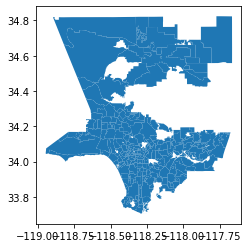

In [35]:
places_map_geo.plot()